# 6.06: Advanced Feature Engineering & Creation (E-Commerce Example)

In this lecture, we will demonstrates **step-by-step feature creation** using a synthetic e-commerce orders dataset.
We’ll go through:
1. Creating synthetic e-commerce data
2. Numerical feature creation
3. Date/Time features
4. Customer-level aggregates
5. Product/Category features
6. Categorical encoding
7. Text features from reviews
8. Interaction features
9. Pipeline + Model training

### 1. Creating synthetic e-commerce data

In [2]:
import numpy as np
import pandas as pd
from datetime import timedelta

# matplotlib & seaborn
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
n = 1000

In [3]:
df = pd.DataFrame({
    'order_id': [f'O{i}' for i in range(1, n+1)],
    'customer_id': np.random.choice([f'C{i}' for i in range(1, 201)], n),
    'order_date': pd.to_datetime('2021-01-01') + pd.to_timedelta(np.random.randint(0, 365, n), unit='D'),
    'ship_date': pd.to_datetime('2021-01-01') + pd.to_timedelta(np.random.randint(1, 370, n), unit='D'),
    'product_id': np.random.choice([f'P{i}' for i in range(1, 501)], n),
    'category': np.random.choice(['Electronics','Clothing','Furniture','Toys','Books'], n),
    'price': np.random.randint(200, 50000, n),
    'quantity': np.random.randint(1, 5, n),
    'payment_type': np.random.choice(['Credit Card','Debit Card','UPI','COD'], n),
    'city': np.random.choice([f'City_{i}' for i in range(1, 51)], n),
    'review_text': np.random.choice(['Great product','Bad service','Loved it','Not good','Excellent','Okay experience'], n)
})

# Target variable: returned (simulate)
df['returned'] = ((df['price'] < 5000).astype(int) + (df['category'] == 'Clothing').astype(int)) > 0
df['returned'] = df['returned'].astype(int)
df.head()

,order_id,customer_id,order_date,ship_date,product_id,category,price,quantity,payment_type,city,review_text,returned
0,O1,C103,2021-08-24,2021-09-04,P495,Books,33922,3,COD,City_30,Great product,0
1,O2,C180,2021-03-24,2021-05-06,P424,Books,10825,2,Credit Card,City_40,Loved it,0
2,O3,C93,2021-02-11,2021-09-26,P294,Books,1829,4,Debit Card,City_7,Excellent,1
3,O4,C15,2021-04-11,2021-05-12,P444,Furniture,11173,3,Credit Card,City_32,Bad service,0
4,O5,C107,2021-01-06,2021-08-26,P59,Books,7059,1,COD,City_48,Excellent,0


### Step 1: Simple Numerical Features

In [4]:
df['order_value'] = df['price'] * df['quantity']

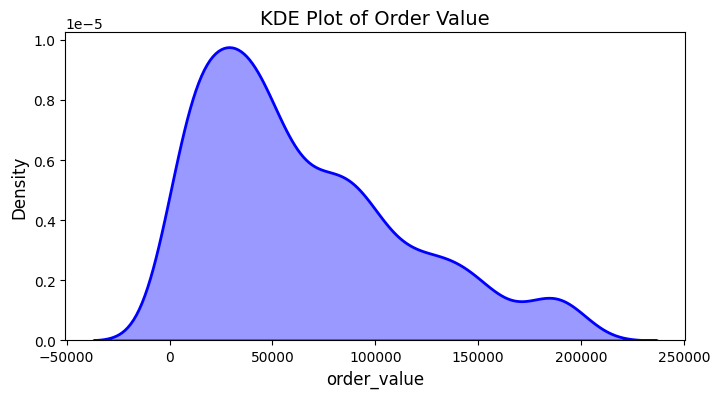

In [5]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df["order_value"], fill=True, color="blue", alpha=0.4, linewidth=2)

plt.title("KDE Plot of Order Value", fontsize=14)
plt.xlabel("order_value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.show()

In [6]:
df['log_order_value'] = np.log1p(df['order_value'])

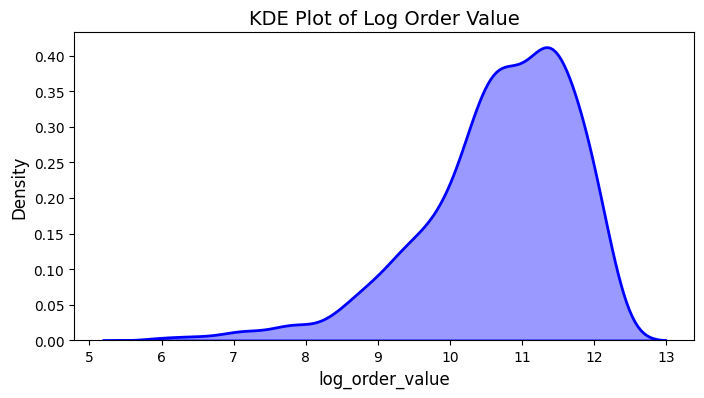

In [7]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df["log_order_value"], fill=True, color="blue", alpha=0.4, linewidth=2)

plt.title("KDE Plot of Log Order Value", fontsize=14)
plt.xlabel("log_order_value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.show()

### Step 2: Date/Time Features

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_id         1000 non-null   object        
 1   customer_id      1000 non-null   object        
 2   order_date       1000 non-null   datetime64[ns]
 3   ship_date        1000 non-null   datetime64[ns]
 4   product_id       1000 non-null   object        
 5   category         1000 non-null   object        
 6   price            1000 non-null   int32         
 7   quantity         1000 non-null   int32         
 8   payment_type     1000 non-null   object        
 9   city             1000 non-null   object        
 10  review_text      1000 non-null   object        
 11  returned         1000 non-null   int64         
 12  order_value      1000 non-null   int32         
 13  log_order_value  1000 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int32(3

In [28]:
df['order_dow'] = df['order_date'].dt.dayofweek
df['order_month'] = df['order_date'].dt.month
df['ship_delay'] = (df['ship_date'] - df['order_date']).dt.days

# cyclical feature encoding trick
df['order_month_sin'] = np.sin(2 * np.pi * df['order_month'] / 12)
df['order_month_cos'] = np.cos(2 * np.pi * df['order_month'] / 12)

In [30]:
df[['order_date','ship_date','order_dow','order_month','ship_delay']].head()

,order_date,ship_date,order_dow,order_month,ship_delay
0,2021-08-24,2021-09-04,1,8,11
1,2021-03-24,2021-05-06,2,3,43
2,2021-02-11,2021-09-26,3,2,227
3,2021-04-11,2021-05-12,6,4,31
4,2021-01-06,2021-08-26,2,1,232


**cyclical feature encoding**
- Suppose you have a feature like month of the year (`order_month ∈ {1, 2, ..., 12}`).
- If you encode it directly as numbers (1–12), the model may think December (12) and January (1) are far apart,
  
  while in reality, they are neighbors in the cycle of a year.
- To fix this, we map months into a circle using sine and cosine.
- With both sin & cos, each month gets a unique 2D coordinate on the circle.

### Step 3: Customer-Level Aggregates

In [32]:
customer_agg = df.groupby('customer_id').agg({
    'order_value': ['mean','sum','count'],
    'returned': 'mean'
}).reset_index()

customer_agg.head()

customer_id order_value                returned
                     mean     sum count      mean
0          C1    83224.25  665794     8  0.125000
1         C10    60626.00  121252     2  0.500000
2        C100   100058.25  400233     4  0.500000
3        C101    52584.00  368088     7  0.285714
4        C102    34390.00   68780     2  0.000000

In [33]:
customer_agg.columns

MultiIndex([('customer_id',      ''),
            ('order_value',  'mean'),
            ('order_value',   'sum'),
            ('order_value', 'count'),
            (   'returned',  'mean')],
           )

In [34]:
customer_agg.columns = ['customer_id','cust_avg_order_val','cust_total_spent','cust_order_count','cust_return_rate']

In [35]:
customer_agg.head()

,customer_id,cust_avg_order_val,cust_total_spent,cust_order_count,cust_return_rate
0,C1,83224.25,665794,8,0.125000
1,C10,60626.00,121252,2,0.500000
2,C100,100058.25,400233,4,0.500000
3,C101,52584.00,368088,7,0.285714
4,C102,34390.00,68780,2,0.000000


In [36]:
df = df.merge(customer_agg, on='customer_id', how='left')
df[['customer_id','cust_avg_order_val','cust_order_count','cust_return_rate']].head()

,customer_id,cust_avg_order_val,cust_order_count,cust_return_rate
0,C103,73930.833333,6,0.333333
1,C180,71166.833333,6,0.166667
2,C93,38970.571429,7,0.285714
3,C15,35871.285714,7,0.428571
4,C107,76688.333333,3,0.000000


In [39]:
print(df.head())

  order_id customer_id order_date  ship_date product_id   category  price  \
0       O1        C103 2021-08-24 2021-09-04       P495      Books  33922   
1       O2        C180 2021-03-24 2021-05-06       P424      Books  10825   
2       O3         C93 2021-02-11 2021-09-26       P294      Books   1829   
3       O4         C15 2021-04-11 2021-05-12       P444  Furniture  11173   
4       O5        C107 2021-01-06 2021-08-26        P59      Books   7059   

   quantity payment_type     city  ... log_order_value  order_dow  \
0         3          COD  City_30  ...       11.530431          1   
1         2  Credit Card  City_40  ...        9.982761          2   
2         4   Debit Card   City_7  ...        8.897819          3   
3         3  Credit Card  City_32  ...       10.419868          6   
4         1          COD  City_48  ...        8.862059          2   

   order_month  ship_delay  order_month_sin  order_month_cos  \
0            8          11        -0.866025    -5.000000e-

### Step 4: Category Features

In [41]:
cat_agg = df.groupby('category').agg({
    'order_value': 'mean',
    'returned': 'mean',
    'order_id': 'count'
}).reset_index()
cat_agg.columns = ['category','cat_avg_order_val','cat_return_rate','cat_order_count']

**Be careful about data leakage**
- Product X has 10 orders, 4 returned → return rate = 0.4.
- If you encode all rows with 0.4, you are already using information from the target column, 
  including the row you’re trying to predict. That’s leakage.

In [42]:
df = df.merge(cat_agg, on='category', how='left')

In [43]:
df[['category','cat_avg_order_val','cat_return_rate']].head()

,category,cat_avg_order_val,cat_return_rate
0,Books,67780.400000,0.075000
1,Books,67780.400000,0.075000
2,Books,67780.400000,0.075000
3,Furniture,66862.686567,0.124378
4,Books,67780.400000,0.075000


### Step 5: Categorical Encoding (Frequency Encoding for City)

In [50]:
df['city'].value_counts()

city
City_38    32
City_21    28
City_10    27
City_12    27
City_5     27
City_42    25
City_39    25
City_4     24
City_31    24
City_18    24
City_45    23
City_23    23
City_7     22
City_48    22
City_2     22
City_13    22
City_26    22
City_34    22
City_44    22
City_15    21
City_28    20
City_24    20
City_40    20
City_17    20
City_16    19
City_49    19
City_9     19
City_20    19
City_37    19
City_3     19
City_8     19
City_11    18
City_19    18
City_30    18
City_27    18
City_50    18
City_36    18
City_29    18
City_35    18
City_6     17
City_33    16
City_22    16
City_46    15
City_1     15
City_25    14
City_32    14
City_47    14
City_14    14
City_41    13
City_43    11
Name: count, dtype: int64

In [44]:
# why not Target Encoding ? - data leakage
city_counts = df['city'].value_counts()
df['city_freq'] = df['city'].map(city_counts)

In [45]:
df[['city','city_freq']].head()

,city,city_freq
0,City_30,18
1,City_40,20
2,City_7,22
3,City_32,14
4,City_48,22


In [51]:
df['payment_type'].value_counts()

payment_type
Debit Card     267
Credit Card    256
UPI            239
COD            238
Name: count, dtype: int64

### Step 6: Text Features from Reviews

In [46]:
df['review_len'] = df['review_text'].str.len()
df['review_word_count'] = df['review_text'].str.split().str.len()
df[['review_text','review_len','review_word_count']].head()

,review_text,review_len,review_word_count
0,Great product,13,2
1,Loved it,8,2
2,Excellent,9,1
3,Bad service,11,2
4,Excellent,9,1


In [ ]:
# Embedding Types

### Step 7: Interaction Features

In [47]:
# This feature captures the interaction between order_value and ship_delay.
# Instead of letting the model “discover” the nonlinear interaction between order_value and ship_delay, you give it directly.
df['val_per_delay'] = df['order_value'] / (df['ship_delay']+1)
df[['order_value','ship_delay','val_per_delay']].head()

,order_value,ship_delay,val_per_delay
0,101766,11,8480.500000
1,21650,43,492.045455
2,7316,227,32.087719
3,33519,31,1047.468750
4,7059,232,30.296137


### Step 8: Selecting features for modelling

In [48]:
df.columns

Index(['order_id', 'customer_id', 'order_date', 'ship_date', 'product_id',
       'category', 'price', 'quantity', 'payment_type', 'city', 'review_text',
       'returned', 'order_value', 'log_order_value', 'order_dow',
       'order_month', 'ship_delay', 'order_month_sin', 'order_month_cos',
       'cust_avg_order_val', 'cust_total_spent', 'cust_order_count',
       'cust_return_rate', 'cat_avg_order_val', 'cat_return_rate',
       'cat_order_count', 'city_freq', 'review_len', 'review_word_count',
       'val_per_delay'],
      dtype='object')

In [49]:
print(df.head())

  order_id customer_id order_date  ship_date product_id   category  price  \
0       O1        C103 2021-08-24 2021-09-04       P495      Books  33922   
1       O2        C180 2021-03-24 2021-05-06       P424      Books  10825   
2       O3         C93 2021-02-11 2021-09-26       P294      Books   1829   
3       O4         C15 2021-04-11 2021-05-12       P444  Furniture  11173   
4       O5        C107 2021-01-06 2021-08-26        P59      Books   7059   

   quantity payment_type     city  ... cust_total_spent  cust_order_count  \
0         3          COD  City_30  ...           443585                 6   
1         2  Credit Card  City_40  ...           427001                 6   
2         4   Debit Card   City_7  ...           272794                 7   
3         3  Credit Card  City_32  ...           251099                 7   
4         1          COD  City_48  ...           230065                 3   

   cust_return_rate  cat_avg_order_val  cat_return_rate  cat_order_count  

In [56]:
df_eng = df[['price', 'quantity', 'log_order_value', 'order_dow',
       'order_month', 'ship_delay', 'order_month_sin', 'order_month_cos',
       'cust_avg_order_val', 'cust_total_spent', 'cust_order_count',
       'cust_return_rate', 'cat_avg_order_val', 'cat_return_rate',
       'cat_order_count', 'city_freq', 'review_len', 'review_word_count',
       'val_per_delay', 'returned']]

In [57]:
df_eng.head()

,price,quantity,log_order_value,order_dow,order_month,ship_delay,order_month_sin,order_month_cos,cust_avg_order_val,cust_total_spent,cust_order_count,cust_return_rate,cat_avg_order_val,cat_return_rate,cat_order_count,city_freq,review_len,review_word_count,val_per_delay,returned
0,33922,3,11.530431,1,8,11,-0.866025,-5.000000e-01,73930.833333,443585,6,0.333333,67780.400000,0.075000,200,18,13,2,8480.500000,0
1,10825,2,9.982761,2,3,43,1.000000,6.123234e-17,71166.833333,427001,6,0.166667,67780.400000,0.075000,200,20,8,2,492.045455,0
2,1829,4,8.897819,3,2,227,0.866025,5.000000e-01,38970.571429,272794,7,0.285714,67780.400000,0.075000,200,22,9,1,32.087719,1
3,11173,3,10.419868,6,4,31,0.866025,-5.000000e-01,35871.285714,251099,7,0.428571,66862.686567,0.124378,201,14,11,2,1047.468750,0
4,7059,1,8.862059,2,1,232,0.500000,8.660254e-01,76688.333333,230065,3,0.000000,67780.400000,0.075000,200,22,9,1,30.296137,0


### Summary Time

In [ ]:
- creating a synthetic ecommerce dataset
- creating new features from existing - domain understanding
- handling datetime column properly
- creating multiple aggregate values for categorical data - Category, Customer level aggregation
- handling categorical data
- text feature preprocessing
- feature selection